In [99]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram

In [100]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [101]:
from keras import regularizers
import os
mylist= os.listdir('raw/audio')

In [102]:
type(mylist)

list

In [103]:
print(mylist[25])

03-02-05-02-02-02-11.wav


In [104]:
print(mylist[25][6:-16])

05


In [105]:
data, sampling_rate = librosa.load('raw/audio/03-02-05-01-01-01-11.wav')

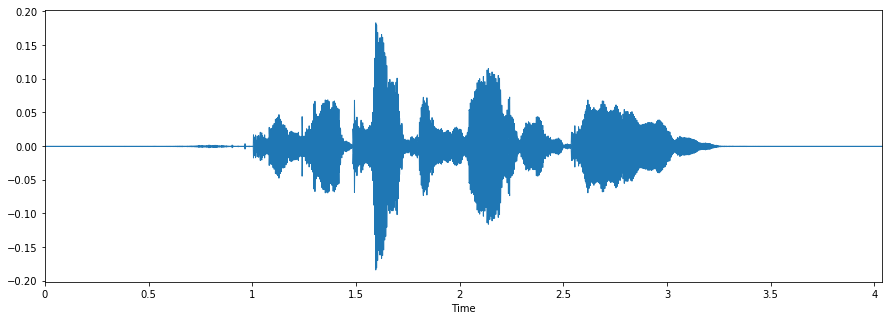

In [106]:
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

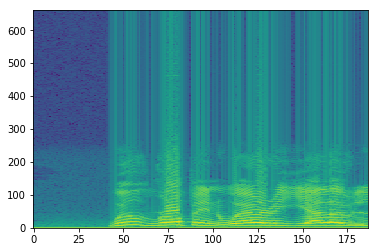

(187, 661)


In [107]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('raw/audio/f10.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()
print(X.shape)

In [108]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [109]:
labels = pd.DataFrame(feeling_list)

In [110]:
labels[:10]

,0
0,male_calm
1,male_happy
2,male_sad
3,female_fearful
4,female_happy
5,male_sad
6,male_happy
7,male_happy
8,male_sad
9,female_angry


In [113]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('raw/audio/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [114]:
df[:5]

,feature
0,"[-63.13176294109655, -61.88816425655823, -59.6..."
1,"[-48.36177728012693, -50.771554800395116, -53...."
2,"[-54.813110988823844, -54.08422531963879, -52...."
3,"[-44.96161015480714, -44.96161015480714, -44.9..."
4,"[-57.75861846089068, -58.00409250933482, -57.4..."


In [115]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [116]:
newdf = pd.concat([df3,labels], axis=1)

In [117]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [118]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-63.131763,-61.888164,-59.611081,-57.938644,-61.089253,-60.685396,-62.597224,-68.623738,-69.007235,-66.853778,...,-63.206008,-60.798756,-60.709084,-56.783297,-55.975401,-61.550989,-63.805746,-60.823494,-57.963688,male_calm
1,-48.361777,-50.771555,-53.175124,-51.937613,-50.650233,-50.295454,-51.304674,-51.800360,-52.324860,-52.498948,...,-22.325424,-26.888806,-28.543322,-27.001353,-24.760062,-23.173327,-22.507638,-14.675778,-9.021776,male_happy
2,-54.813111,-54.084225,-52.972346,-51.749586,-51.722706,-53.345300,-52.670165,-52.169738,-51.282514,-51.591946,...,-28.196284,-27.515483,-27.832882,-27.374633,-28.211750,-29.666823,-29.675098,-22.329938,-17.404168,male_sad
3,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,-44.961610,...,-39.911897,-39.489047,-38.742738,-37.552473,-38.571825,-38.862552,-38.311068,-33.737125,-27.476521,female_fearful
4,-57.758618,-58.004093,-57.478262,-57.790908,-57.986003,-57.912584,-57.913812,-57.861677,-57.912662,-57.388150,...,-43.387692,-49.357955,-44.845305,-37.251156,-32.966978,-33.814363,-36.056942,-22.924710,-14.684229,female_happy


In [119]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
501,-43.032377,-43.404281,-43.914429,-43.914429,-43.914429,-43.485842,-43.896408,-43.602694,-43.914429,-43.914429,...,-40.425540,-40.812529,-41.539751,-42.023315,-42.643756,-42.186344,-41.791094,-40.849020,-39.548465,male_angry
54,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,...,-36.108002,-36.096427,-36.238059,-37.435275,-38.044236,-38.505617,-39.535250,-38.958541,-35.530043,female_angry
1022,-45.926538,-47.099597,-49.111809,-49.751451,-50.000951,-48.261825,-47.427477,-47.751723,-47.489718,-48.226338,...,-25.255584,-23.120896,-21.898277,-22.797743,-23.565636,-24.299835,-26.913490,-28.400662,-28.083453,female_angry
1501,-53.769216,-55.061158,-53.305227,-51.120282,-52.921001,-52.180352,-53.490261,-54.648841,-52.985473,-51.930319,...,-48.560605,-47.684605,-46.392758,-47.169001,-48.063584,-49.027493,-50.796035,-51.032863,-49.138525,female_sad
1458,-55.357606,-52.655553,-51.013058,-51.590308,-51.428924,-52.504162,-53.887804,-53.887736,-52.021016,-51.118319,...,-52.029958,-52.538735,-52.744339,-53.587089,-54.598380,-57.369939,-58.869701,-58.851182,-58.738000,male_fearful
792,-39.940464,-41.664733,-42.001088,-41.983338,-41.968750,-36.739554,-30.769141,-28.574851,-31.405125,-32.098047,...,-30.493400,-29.974680,-27.453258,-26.796787,-23.994556,-23.910562,-23.620258,-19.923789,-17.185126,male_happy
844,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,...,-16.183297,-13.093471,-12.076940,-10.745269,-10.060971,-11.283584,-14.897975,-9.194204,-3.097675,male_angry
1706,-58.255511,-56.611299,-57.336710,-59.509948,-60.467903,-57.877622,-55.617060,-55.417798,-57.412933,-59.437803,...,-27.686674,-27.326098,-25.977829,-27.788152,-27.787378,-28.220510,-28.568290,-21.286059,-15.900004,male_sad
1475,-52.527298,-52.740150,-51.810168,-50.845956,-52.180610,-50.952666,-51.928785,-50.068745,-51.063870,-51.178481,...,-52.454113,-53.226469,-51.588146,-48.858011,-49.559297,-49.241311,-49.745715,-50.692470,-49.275900,female_sad
946,-58.447369,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,...,-45.291419,-43.696042,-43.902750,-44.766666,-42.944110,-44.041733,-43.189507,-29.960326,-22.695266,female_sad


In [120]:
rnewdf=rnewdf.fillna(0)

In [121]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [122]:
train[0:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
501,-43.032377,-43.404281,-43.914429,-43.914429,-43.914429,-43.485842,-43.896408,-43.602694,-43.914429,-43.914429,...,-40.425540,-40.812529,-41.539751,-42.023315,-42.643756,-42.186344,-41.791094,-40.849020,-39.548465,male_angry
54,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,-47.779551,...,-36.108002,-36.096427,-36.238059,-37.435275,-38.044236,-38.505617,-39.535250,-38.958541,-35.530043,female_angry
1022,-45.926538,-47.099597,-49.111809,-49.751451,-50.000951,-48.261825,-47.427477,-47.751723,-47.489718,-48.226338,...,-25.255584,-23.120896,-21.898277,-22.797743,-23.565636,-24.299835,-26.913490,-28.400662,-28.083453,female_angry
1501,-53.769216,-55.061158,-53.305227,-51.120282,-52.921001,-52.180352,-53.490261,-54.648841,-52.985473,-51.930319,...,-48.560605,-47.684605,-46.392758,-47.169001,-48.063584,-49.027493,-50.796035,-51.032863,-49.138525,female_sad
1458,-55.357606,-52.655553,-51.013058,-51.590308,-51.428924,-52.504162,-53.887804,-53.887736,-52.021016,-51.118319,...,-52.029958,-52.538735,-52.744339,-53.587089,-54.598380,-57.369939,-58.869701,-58.851182,-58.738000,male_fearful
792,-39.940464,-41.664733,-42.001088,-41.983338,-41.968750,-36.739554,-30.769141,-28.574851,-31.405125,-32.098047,...,-30.493400,-29.974680,-27.453258,-26.796787,-23.994556,-23.910562,-23.620258,-19.923789,-17.185126,male_happy
844,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,-45.655834,...,-16.183297,-13.093471,-12.076940,-10.745269,-10.060971,-11.283584,-14.897975,-9.194204,-3.097675,male_angry
1706,-58.255511,-56.611299,-57.336710,-59.509948,-60.467903,-57.877622,-55.617060,-55.417798,-57.412933,-59.437803,...,-27.686674,-27.326098,-25.977829,-27.788152,-27.787378,-28.220510,-28.568290,-21.286059,-15.900004,male_sad
1475,-52.527298,-52.740150,-51.810168,-50.845956,-52.180610,-50.952666,-51.928785,-50.068745,-51.063870,-51.178481,...,-52.454113,-53.226469,-51.588146,-48.858011,-49.559297,-49.241311,-49.745715,-50.692470,-49.275900,female_sad
946,-58.447369,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,-58.416637,...,-45.291419,-43.696042,-43.902750,-44.766666,-42.944110,-44.041733,-43.189507,-29.960326,-22.695266,female_sad


In [123]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [124]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import numpy

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

##numpy.save('classes.npy', lb.classes_)  

In [125]:
y_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [126]:
X_train.shape

(1587, 216)

In [127]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [156]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [157]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 216, 256)          1536      
_________________________________________________________________
activation_36 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_37 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 27, 128)           82048     
__________

In [165]:
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])

In [167]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test))

Train on 1587 samples, validate on 353 samples
Epoch 1/100
1587/1587 [==============================] - 7s 5ms/step - loss: 0.3052 - acc: 0.8960 - val_loss: 2.6537 - val_acc: 0.4504
Epoch 2/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.2866 - acc: 0.8916 - val_loss: 2.3878 - val_acc: 0.4278
Epoch 3/100
1587/1587 [==============================] - 7s 5ms/step - loss: 0.2459 - acc: 0.9105 - val_loss: 2.4373 - val_acc: 0.4221
Epoch 4/100
1587/1587 [==============================] - 7s 5ms/step - loss: 0.2419 - acc: 0.9130 - val_loss: 2.5440 - val_acc: 0.4136
Epoch 5/100
1587/1587 [==============================] - 7s 5ms/step - loss: 0.2123 - acc: 0.9269 - val_loss: 3.0110 - val_acc: 0.4504
Epoch 6/100
1587/1587 [==============================] - 8s 5ms/step - loss: 0.2035 - acc: 0.9231 - val_loss: 2.8719 - val_acc: 0.4504
Epoch 7/100
1587/1587 [==============================] - 7s 5ms/step - loss: 0.1834 - acc: 0.9357 - val_loss: 3.1987 - val_acc: 0.4363
Epoch 8/

Epoch 61/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.1089 - acc: 0.9616 - val_loss: 4.1138 - val_acc: 0.4051
Epoch 62/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.1154 - acc: 0.9559 - val_loss: 3.8915 - val_acc: 0.4278
Epoch 63/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.0560 - acc: 0.9786 - val_loss: 4.1626 - val_acc: 0.4363
Epoch 64/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.0402 - acc: 0.9855 - val_loss: 4.1213 - val_acc: 0.4476
Epoch 65/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.0904 - acc: 0.9698 - val_loss: 4.1112 - val_acc: 0.3881
Epoch 66/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.1152 - acc: 0.9597 - val_loss: 4.1064 - val_acc: 0.3909
Epoch 67/100
1587/1587 [==============================] - 7s 4ms/step - loss: 0.0863 - acc: 0.9698 - val_loss: 3.8718 - val_acc: 0.4278
Epoch 68/100
1587/1587 [========================

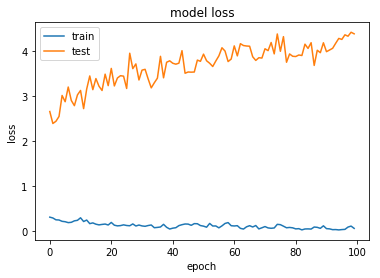

In [168]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from keras.models import load_model
lmodel=load_model("Emotion_Voice_Detection_Model.h5")

In [36]:
preds=lmodel.predict(x_testcnn,batch_size=32,verbose=1)

416/416 [==============================] - 0s 949us/step


In [37]:
preds1=preds.argmax(axis=1)
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))

preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]


,predictedvalues
0,male_happy
1,male_angry
2,male_fearful
3,male_calm
4,female_sad
5,male_happy
6,female_fearful
7,female_calm
8,male_angry
9,male_happy


In [38]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]


,actualvalues
0,male_happy
1,male_fearful
2,male_fearful
3,male_fearful
4,female_sad
5,male_angry
6,female_fearful
7,female_calm
8,male_angry
9,male_calm


In [39]:
finaldf = actualdf.join(preddf)
finaldf[40:50]

,actualvalues,predictedvalues
40,male_fearful,male_fearful
41,male_calm,male_happy
42,female_happy,female_happy
43,female_sad,female_sad
44,female_sad,female_sad
45,male_sad,male_sad
46,female_sad,female_sad
47,male_angry,male_happy
48,female_happy,female_happy
49,female_calm,female_sad


In [42]:
score=lmodel.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (lmodel.metrics_names[1], score[1]*100))

acc: 61.54%


In [41]:
from tkinter import *
from PIL import Image, ImageTk
from tkinter import filedialog
master = Tk()
var = StringVar()
emo = StringVar()
master.title('EMOTION DETECTION')
##master.overrideredirect(True)
master.geometry("{0}x{1}+0+0".format(master.winfo_screenwidth(), master.winfo_screenheight()))
def callback():
    import pyaudio
    import wave

    CHUNK = 1024 
    FORMAT = pyaudio.paInt16 #paInt8
    CHANNELS = 2 
    RATE = 44100 #sample rate
    RECORD_SECONDS = 4
    WAVE_OUTPUT_FILENAME = "output.wav"

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,

                frames_per_buffer=CHUNK) #buffer

    print("* recording")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data) # 2 bytes(16 bits) per channel

    print("* done recording")

    stream.stop_stream()
    stream.close()
    p.terminate()
    
 

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
def findemo():
   
    import pandas as pd
    import librosa
    import numpy as np
    from keras.utils import np_utils
    from sklearn.preprocessing import LabelEncoder
   
    from keras.models import load_model
    lmodel=load_model("Emotion_Voice_Detection_Model.h5")
    
    lb = LabelEncoder()
    lb.classes_ = np.load('classes.npy')
    data, sampling_rate = librosa.load(master.filename)
    X, sample_rate = librosa.load(master.filename, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T 
    
    twodim= np.expand_dims(livedf2, axis=2)
    
    livepreds = lmodel.predict(twodim,batch_size=32,verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print(livepredictions[0])
    emo.set(livepredictions[0])  
   
    
def upload():
    
    global filename
    master.filename =  filedialog.askopenfilename(initialdir = "/home/user/main_project/",title = "Select file",filetypes = (("audio","*.wav"),("all files","*.*")))
    print(master.filename)
    
def detectemotion():
    import pandas as pd
    import librosa
    import numpy as np
    from keras.utils import np_utils
    from sklearn.preprocessing import LabelEncoder
   
    from keras.models import load_model
    lmodel=load_model("Emotion_Voice_Detection_Model.h5")
    
    lb = LabelEncoder()
    lb.classes_ = np.load('classes.npy')
    
    data, sampling_rate = librosa.load('output.wav')
    X, sample_rate = librosa.load('output.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T 
    
    twodim= np.expand_dims(livedf2, axis=2)
    
    livepreds = lmodel.predict(twodim,batch_size=32,verbose=1)
    livepreds1=livepreds.argmax(axis=1)
    liveabc = livepreds1.astype(int).flatten()
    livepredictions = (lb.inverse_transform((liveabc)))
    print(livepredictions[0])
    var.set(livepredictions[0])
 
    
label1 = Label(master, text="UPLOAD VOICE",font=("Arial",18))
b1 = Button(master, text="BROWSE", command=upload)
label2 = Label(master, text="DETECT EMOTION",font=("Arial",18))
b2 = Button(master, text="DETECT", command=findemo)
label3 = Label(master,textvariable=emo,font=("Arial",18))


label4 = Label(master, text="RECORD YOUR VOICE          ",font=("Arial",18))
b3 = Button(master, text="RECORD", command=callback)
label5 = Label(master, text="DETECT EMOTION        ",font=("Arial",18))
b4 = Button(master, text="DETECT",command=detectemotion)
label6 = Label(master,textvariable=var,font=("Arial",18))
b5 = Button(master, text="EXIT",command=master.destroy)

label1.place(x=200,y=10)
b1.place(x=500,y=10)
label2.place(x=200,y=50)
b2.place(x=500,y=50)
label3.place(x=200,y=90)

b3.place(x=500,y=180)
label4.place(x=200,y=180)
b4.place(x=500,y=220)
label5.place(x=200,y=220)
b5.place(x=500,y=300)
label6.place(x=200,y=260)


mainloop()
